# **ALGORITMOS DE APRENDIZAJE SUPERVISADO: KNN - Paris Housing Price**
Predicción de precios de las casas de París. El dataset contiene una serie de datos de casas, como por ejemplo número de habitaciones, año de construcción, piscina, garaje, etc. y el precio por el que se han vendido. El objetivo es, dada una serie de parámetros, predecir el precio que debe tener la casa.

In [1]:
#@title Importación de librerías
import pandas as pd
import urllib.request
import tempfile
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import statistics
import warnings
warnings.filterwarnings('ignore')
# Descargar clase Preprocessing para el tratado del dataset
urllib.request.urlretrieve('https://raw.githubusercontent.com/MattJCR/Algoritmo-KNN/master/Preprocessing.py', 'Preprocessing.py')
from Preprocessing import CleanData as cd

In [2]:
#@title Obtención del dataset

# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/MattJCR/Algoritmo-KNN/master/dataset/ParisHousing.csv'

# Descargar el archivo CSV
response = urllib.request.urlopen(url)

# Crear un archivo temporal para guardar el archivo CSV descargado
temp = tempfile.NamedTemporaryFile()

# Escribir los datos descargados en el archivo temporal
temp.write(response.read())

# Mover el puntero al inicio del archivo
temp.seek(0)

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(temp)

# Cerrar el archivo temporal
temp.close()

df

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


In [3]:
#@title Mostrado de primeras lineas del dataset
df.head(5)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [4]:
#@title Mostrado de ultimas lineas del dataset
df.tail(5)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0
9999,1440,84,0,0,49,18412,6,10,1994,1,0,8485,2024,278,1,6,146708.4


In [5]:
#@title Obtener el resumen estadístico del DataFrame
df.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07


In [6]:
#@title Limpiado de datos
df = cd.clean(df)
df

,squaremeters,numberofrooms,hasyard,haspool,floors,citycode,citypartrange,numprevowners,made,isnewbuilt,hasstormprotector,basement,attic,garage,hasstorageroom,hasguestroom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

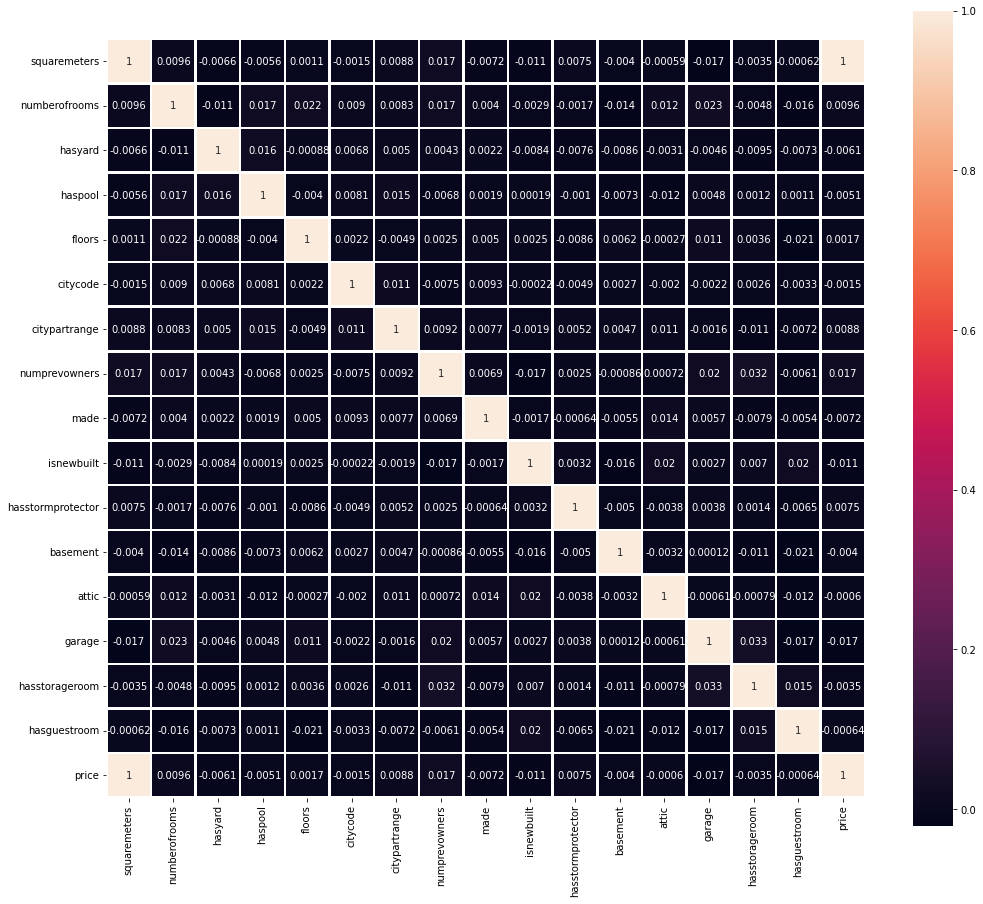

In [7]:
#@title Mostrar un mapa de calor que indique la correlación entre variables

# Calcular la correlación entre las variables del DataFrame
corr = df.corr()

# Mostrar el mapa de calor de la correlación
plt.figure(figsize=(17, 15))
sns.heatmap(corr,square=True,annot=True,linewidths=1.5)
plt


## **Seleccionar las características a tener en cuenta en el estudio**
Para este estudio no vamos a eliminar ninguna de las columnas ya que apenas tienen impacto sobre el precio. La unica columna que tiene una relacion directa con el precio es squaremeters (metros cuadrados).

In [8]:
#@title Separar datos entre datos de entrada y etiquetas (resultados)

# Obtenemos la columna price
df_price = df['price']

# Eliminamos la columna price del dataframe
df = df.drop('price',axis=1)

In [9]:
#@title Separar datos entre entrenamiento y prueba (usando un 75% para entrenamiento y 25% para test)

x_train,x_test,y_train, y_test = train_test_split(df,df_price,random_state=1,train_size=0.75)

# **Entrenamiento y predicción**

In [10]:
#@title Importamos el modelo KNN
modelo_KNN = KNeighborsRegressor(n_neighbors=3, weights="uniform")

In [11]:
#@title Entrenamos el modelo KNN
modelo_KNN.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [12]:
#@title Realizar una predicción con los datos de prueba
predict = modelo_KNN.predict(x_test)
predict

array([7720330.76666667, 7748091.9       , 1701528.1       , ...,
       8067136.7       , 4513895.86666667, 2056470.9       ])

# **Evaluación**

In [13]:
#@title Mostrar la predicción realizada (imprimir la variable con la predicción)
example = pd.DataFrame({'squaremeters':[80771], 'numberofrooms':[2], 'hasyard':[0], 'haspool':[0], 'floors':[2],
        'citycode':[1234], 'citypartrange':[2], 'numprevowners':[1], 'made':[2011], 'isnewbuilt':[1], 'hasstormprotector':[0], 
        'basement':[2937], 'attic':[9005], 'garage':[345], 'hasstorageroom':[0], 'hasguestroom':[1]})
modelo_KNN.predict(example)[0]

7913441.0

In [14]:
#@title Mostrar el error cuadrático medio (mean_squared_error)
mean_squared_error(y_test, predict)

6952552328.083311

In [15]:
#@title Mostrar el error absoluto medio (mean_absolute_error)
mean_absolute_error(y_test, predict)

66055.77808

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

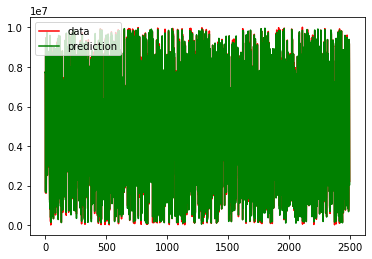

In [16]:
#@title Representar gráficamente los valores predichos con los valores reales.
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx,y_test, c = 'r', label = 'data')
plt.plot(xx,predict, c = 'g', label = 'prediction')
plt.axis('tight')
plt.legend()
plt

# **Optimización de hiperparámetros**
Calcula la combinación de parámetros óptima (uniform o distance; valor de k). Para ello realiza ejecuciones con cada uno de los valores uniform y distance para los valores de k desde 1 a 30.

Cada ejecución anterior se deberá hacer usando validación cruzada (por ejemplo n_splits = 5). Con ello obtendremos una medida de bondad del modelo (accuracy_score o mean_absolute_error)), como lo ejecutaremos 5 veces, calcularemos la media de esas 5 ejecuciones.

In [17]:
optimization_result = {'uniform':[],'distance':[]}
for k in range(1,30):
  modelo_KNN = KNeighborsRegressor(n_neighbors=k, weights="uniform")
  # Instanciar KFold con 5 divisiones y una semilla aleatoria fija
  kfold = KFold(n_splits=5)
  # Dividir los datos en conjuntos de entrenamiento y validación
  result = []
  for train_index, val_index in kfold.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[val_index]
    y_train, y_test = df_price.iloc[train_index], df_price.iloc[val_index]
        
    # Entrenar y evaluar el modelo con los conjuntos de entrenamiento y validación
    modelo_KNN.fit(x_train, y_train)
    predict = modelo_KNN.predict(x_test)
    score = mean_absolute_error(y_test, predict)
    #print(f'Score: {score:.2f}')
    result.append(score)
  optimization_result['uniform'].append(statistics.mean(result))
for k in range(1,30):
  modelo_KNN = KNeighborsRegressor(n_neighbors=k, weights="distance")
  # Instanciar KFold con 5 divisiones y una semilla aleatoria fija
  kfold = KFold(n_splits=5)
  # Dividir los datos en conjuntos de entrenamiento y validación
  result = []
  for train_index, val_index in kfold.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[val_index]
    y_train, y_test = df_price.iloc[train_index], df_price.iloc[val_index]
        
    # Entrenar y evaluar el modelo con los conjuntos de entrenamiento y validación
    modelo_KNN.fit(x_train, y_train)
    predict = modelo_KNN.predict(x_test)
    score = mean_absolute_error(y_test, predict)
    #print(f'Score: {score:.2f}')
    result.append(score)
  optimization_result['distance'].append(statistics.mean(result))

In [18]:
#@title Finalmente los parámetros elegidos serán los que den mejor media de esas medidas anteriormente nombradas.

# Obtener el índice del elemento mayor
uniform_min_index = min(enumerate(optimization_result['uniform']), key=lambda x: x[1])[0]
distance_min_index = min(enumerate(optimization_result['distance']), key=lambda x: x[1])[0]
print('uniform[' + str(uniform_min_index) + ']:',optimization_result['uniform'][uniform_min_index],', n_neighbors=' + str(uniform_min_index + 1))
print('distance[' + str(distance_min_index) + ']:',optimization_result['distance'][distance_min_index],', n_neighbors=' + str(distance_min_index + 1))

uniform[25]: 46401.206814230776 , n_neighbors=26
distance[28]: 41794.76920344188 , n_neighbors=29


In [21]:
#@title Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostraremos los resultados.

# Instanciamos el modelo con los parametros óptimos
modelo_KNN = KNeighborsRegressor(n_neighbors=29, weights="distance")

# Creamos los datos de entrenamiento
x_train,x_test,y_train, y_test = train_test_split(df,df_price,random_state=1,train_size=0.75)

# Entrenamos el modelo KNN
modelo_KNN.fit(x_train,y_train)

# Realizamos una predicción con los datos de prueba
predict = modelo_KNN.predict(x_test)

# Obtenemos el error cuadrático medio
squared_error = mean_squared_error(y_test, predict)

# Obtenemos Mostrar el error absoluto medio (mean_absolute_error)
absolute_error = mean_absolute_error(y_test, predict)

print(f'mean_squared_error: {squared_error:.2f}')
print(f'mean_absolute_error: {absolute_error:.2f}')

mean_squared_error: 3467257061.63
mean_absolute_error: 42451.90


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

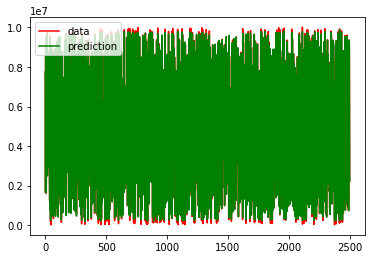

In [22]:
# Representamos gráficamente los valores predichos con los valores reales.
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx,y_test, c = 'r', label = 'data')
plt.plot(xx,predict, c = 'g', label = 'prediction')
plt.axis('tight')
plt.legend()
plt

# **Conclusiones**

El objetivo de este estudio era predecir el precio de las casas en París a partir de un conjunto de características de las mismas. Para ello, se ha realizado un proceso de limpieza de datos para eliminar valores faltantes o incorrectos. También se ha calculado la correlación entre las variables del conjunto de datos para identificar cuáles tienen una mayor influencia en el precio. Todas las columnas del conjunto de datos se han seleccionado para el análisis, ya que ninguna de ellas tiene un impacto significativo en el precio. Los datos se han dividido en un conjunto de entrenamiento y otro de prueba, utilizando una proporción de 75% y 25% respectivamente. Una vez divididos los datos, se ha entrenado un modelo de regresión KNN con los datos de entrenamiento. 

Luego, se ha realizado una predicción con el conjunto de prueba y se ha mostrado el resultado. Además, se han calculado el error cuadrático medio y el error absoluto medio entre los valores reales y la predicción y se ha representado gráficamente.

Para optimizar el modelo, se ha realizado un proceso de validación cruzada para encontrar la combinación óptima de los parámetros "uniform" o "distance" y el valor de "k" para el modelo KNN. Con esto, se ha buscado la combinación de parámetros que mejor se ajuste al conjunto de datos y permita realizar predicciones más precisas. Se han ejecutado el modelo con cada uno de estos valores y se han calculado medidas de bondad del modelo, como el error absoluto medio. 

Luego, se han calculado las medias de estas métricas para cada combinación de parámetros y se han seleccionado los parámetros que den la mejor media. Con esto, se ha logrado optimizar el modelo y mejorar la precisión de las predicciones.

